# Praproses Thesis

Ini sama dengan bipartite 24 thesis, tapi ini full pake API GloBI

Cara json to dataframe https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8

In [1]:
# # reset import package
# def reloadPackageOwn():
#     from importlib import reload  
#     import os # we use os.path.join, os.path.basename
#     import sys # we use sys.path
#     import glob # we use glob.glob
#     import importlib # we use importlib.import_module

#     import_folder = os.getcwd()
#     sys.path.append(import_folder) # this tells python to look in `import_folder` for imports
#     for src_file in glob.glob(os.path.join(import_folder, '*.py')):
#         name = os.path.basename(src_file)[:-3]
#         importlib.import_module(name)
#         reload(sys.modules[name])
#         importlib.import_module(name)
        
# reloadPackageOwn()

In [2]:
import requests
from tqdm import tqdm
import pandas as pd
from owlready2 import get_ontology
import os

from standardization import addTaxonColumn, buat_kolom_taxon_awal
from disambiguation_optimized import buat_kamus_kosong, update_kamus_pake_wikidata, update_df_pake_kamus, update_df_pake_path_ujung
from preprocess import cleaning, splitInteractionToNodeEdge
from disambiguation import removeOtherThanNCBI
from filterNodeEdge import removeNodeAndEdgeByFilter,takeNodeAndEdgeByFilter,removeEdgesNotInNodes

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [3]:
#parameter
virus_txt = 'Fijivirus'.replace(' ','%20')
nama_file = '10fiji'
tipe_interaksi_virus = 'pathogenOf'
tipe_interaksi_tanaman = 'hasPathogen' #hostOf

In [4]:
#0 # Ambil NCBI OBO
ncbi_link = os.getcwd()+'/../data/ncbitaxon.owl'
onto = get_ontology(ncbi_link)
onto.load()
obo = onto.get_namespace('http://purl.obolibrary.org/obo/')

In [5]:
kolom=[
    'source_taxon_external_id',
    'source_taxon_name',
    'source_taxon_path',
    'source_taxon_path_ids',
    'source_taxon_path_ranks',
    
    'interaction_type',
    
    'target_taxon_external_id',
    'target_taxon_name',
    'target_taxon_path',
    'target_taxon_path_ids',
    'target_taxon_path_ranks',
]

interactionType=tipe_interaksi_virus

link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+virus_txt+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
response = requests.get(link)
res=response.json()

if not res['data']:
    print('kosong')
# JSON To Pandas Dataframe
df = pd.json_normalize(res, record_path =['data'])
df.columns = kolom

In [6]:
df #.interaction_type.unique()

,source_taxon_external_id,source_taxon_name,source_taxon_path,source_taxon_path_ids,source_taxon_path_ranks,interaction_type,target_taxon_external_id,target_taxon_name,target_taxon_path,target_taxon_path_ids,target_taxon_path_ranks
0,EOL:540109,Oat sterile dwarf virus,Viruses | Dsrna viruses | Reoviridae | Spinare...,EOL:5006 | EOL:9157927 | EOL:8052 | EOL_V2:116...,null | null | family | subfamily | genus | nul...,pathogenOf,NCBITaxon:331356,Wheat streak mosaic virus--wild rice,None,None,None
1,EOL:540109,Oat sterile dwarf virus,Viruses | Dsrna viruses | Reoviridae | Spinare...,EOL:5006 | EOL:9157927 | EOL:8052 | EOL_V2:116...,null | null | family | subfamily | genus | nul...,pathogenOf,GBIF:2706056,Hordeum vulgare,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | ge...
2,EOL:540109,Oat sterile dwarf virus,Viruses | Dsrna viruses | Reoviridae | Spinare...,EOL:5006 | EOL:9157927 | EOL:8052 | EOL_V2:116...,null | null | family | subfamily | genus | nul...,pathogenOf,NCBITaxon:331356,Wheat streak mosaic virus--wild rice,None,None,None
3,EOL:540109,Oat sterile dwarf virus,Viruses | Dsrna viruses | Reoviridae | Spinare...,EOL:5006 | EOL:9157927 | EOL:8052 | EOL_V2:116...,null | null | family | subfamily | genus | nul...,pathogenOf,GBIF:2706056,Hordeum vulgare,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | ge...
4,EOL:540108,Rice black streaked dwarf virus,Viruses | Dsrna viruses | Reoviridae | Spinare...,EOL:5006 | EOL:9157927 | EOL:8052 | EOL_V2:116...,null | null | family | subfamily | genus | nul...,pathogenOf,NCBITaxon:331356,Wheat streak mosaic virus--wild rice,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
67,EOL:540113,Maize rough dwarf virus,Viruses | | | | Reoviridae | Fijivirus | Ma...,EOL:5006 | | | | EOL:8052 | EOL:67541 | EOL...,kingdom | null | null | null | family | genus ...,pathogenOf,GBIF:2705181,Sorghum bicolor,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | ge...
68,no:match,Rice black-streaked dwarf virus (RBSDV)—genus ...,None,None,None,pathogenOf,GBIF:2703455,Oryza,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | genus
69,no:match,Rice black-streaked dwarf virus (RBSDV)—genus ...,None,None,None,pathogenOf,GBIF:2703455,Oryza,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | genus
70,no:match,Southern rice black-streaked dwarf virus (SRBS...,None,None,None,pathogenOf,GBIF:2703455,Oryza,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | genus


In [7]:
#tes2 data salah
# df2 = {'Name': 'Amy', 'Maths': 89, 'Science': 93}
# df = df.append(df2, ignore_index = True)
# df.loc[len(df.index)]=['GBIF:3523201','Asteridiella boerhaviifolii',None,None,None,'pathogenOf','GBIF:3523201','Asteridiella boerhaviifolii',None,None,None]
# cek='NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732092 | NCBI:2732416 | NCBI:2732424 | NCBI:2732539 | NCBI:10811 | NCBI:10814 | NCBI:260378'
# df.loc[len(df.index)]=['GBIF:3523201','Asteridiella boerhaviifolii',None,cek,None,'pathogenOf','GBIF:3523201','Asteridiella boerhaviifolii',None,None,None]

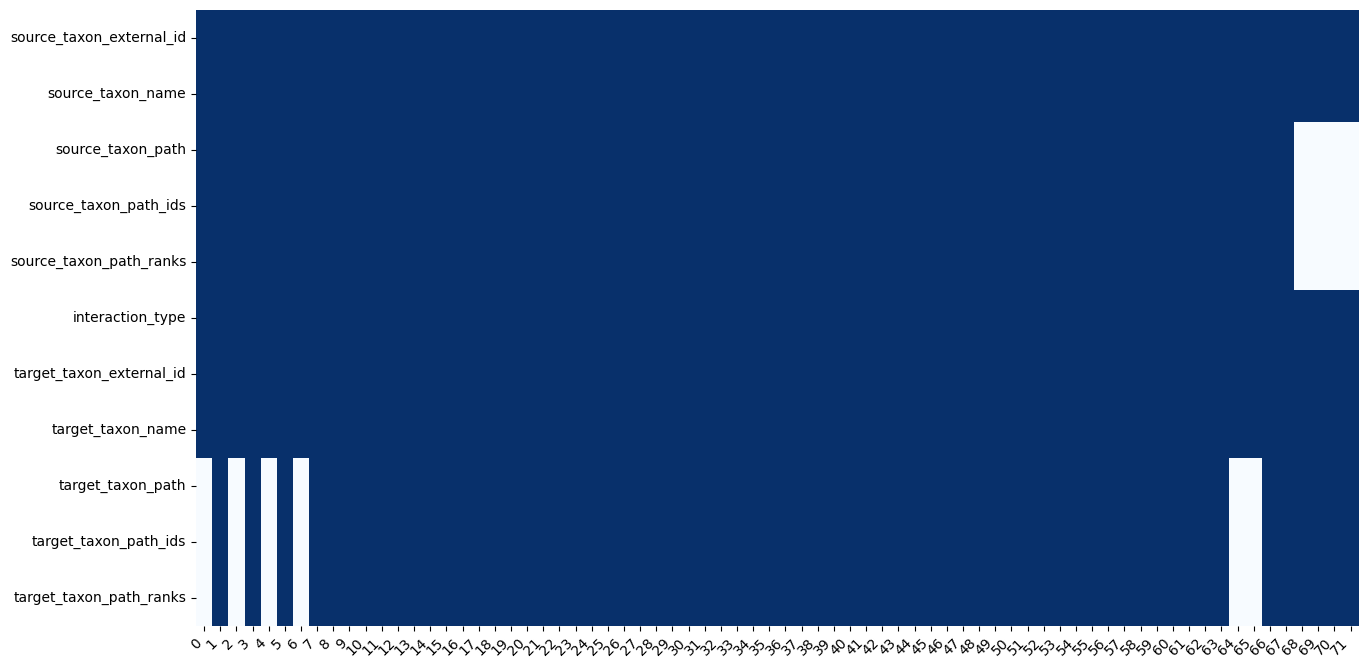

In [8]:
from jcopml.plot import plot_missing_value
plot_missing_value(df)

# Praproses : virus - pathogenOf

### Cleaning

drop duplikasi, drop jika tidak mengandung NCBI dan Taxon path null, drop nama sama beda Id

In [9]:
df=cleaning(df, dropNonNCBI=False)

drop duplicate
sebelum :  72
setelah:  36
drop tidak mengandung NCBI dan taxon pathnya null
sebelum :  36
setelah:  34
drop duplicate nama sama beda id
sebelum :  34
setelah:  33


### Pemisahan kolom

In [10]:
df_node, df_edge = splitInteractionToNodeEdge(df)

In [11]:
print('cek data')
print('node ',df_node.shape)
print('edge ',df_edge.shape)

df_node

cek data
node  (26, 5)
edge  (33, 3)


,taxon_id,taxon_name,taxon_path,taxon_path_ids,taxon_path_rank
0,NCBITaxon:331356,Wheat streak mosaic virus--wild rice,None,None,None
1,GBIF:2706056,Hordeum vulgare,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | ge...
2,GBIF:2705290,Avena sativa,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | ge...
3,NCBI:4565,Triticum aestivum,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...
4,GBIF:5290052,Zea mays,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | ge...
5,GBIF:2703459,Oryza sativa,Plantae | Tracheophyta | Liliopsida | Poales |...,GBIF:6 | GBIF:7707728 | GBIF:196 | GBIF:1369 |...,kingdom | phylum | class | order | family | ge...
6,NCBI:1249733,Cyperus serotinus,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...
7,NCBI:192627,Cenchrus flaccidus,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...
8,NCBI:90397,Echinochloa crus-galli,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...
9,NCBI:121769,Digitaria sanguinalis,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...


### Disambiguasi 
Konversi ke NCBI semua Node (kode di Edge juga)

In [12]:
df_node_sebelum_convert_NCBI = df_node.copy()

In [13]:
kamus_ncbi = buat_kamus_kosong(df_node)
kamus_ncbi = update_kamus_pake_wikidata(kamus_ncbi)
#update dataframe pake kamus
df_node,df_edge = update_df_pake_kamus(kamus_ncbi,df_node,df_edge)
df_node,df_edge = update_df_pake_path_ujung(df_node,df_edge)

['GBIF', 'EOL', 'EOL_V2'] 3  database,  3  kali perulangan akses NCBI
489


HTTPError: HTTP Error 403: Forbidden

### Standardization : Menambah kolom taxon
Menambah kolom taxon ke dalam dataframe

In [ ]:
#buat kolom taxon, default none
df_node = buat_kolom_taxon_awal(df_node)
# isi pake ncbi
df_node = addTaxonColumn(df_node,obo)

#### Hapus kalo masih ada selain NCBI

In [ ]:
df_node, df_edge = removeOtherThanNCBI(df_node,df_edge)

In [ ]:
# Menghapus kolom yang tidak lagi dibutuhkan
# df_node.drop(['taxon_path_ids','taxon_path_rank'], axis=1,inplace=True) #,'taxon_rank'

#hapus edge yang tidak ada nodenya
df_edge = removeEdgesNotInNodes(df_node, df_edge)

# df_edge.drop_duplicates(inplace=True)

kingdom apa saja di data awal

In [ ]:
print(df_node.kingdom.unique())

Node Tanaman

In [ ]:
df_node[df_node.kingdom=='NCBI:33090_Viridiplantae']

# Praproses : Tanaman - has pathogen

In [ ]:
df_node.columns

In [ ]:
import requests
from tqdm import tqdm

df_plant=df_node[df_node.kingdom=='NCBI:33090_Viridiplantae']

kolom=[
    'source_taxon_external_id',
    'source_taxon_name',
    'source_taxon_path',
    'source_taxon_path_ids',
    'source_taxon_path_ranks',
    
    'interaction_type',
    
    'target_taxon_external_id',
    'target_taxon_name',
    'target_taxon_path',
    'target_taxon_path_ids',
    'target_taxon_path_ranks',
]
interactionType=tipe_interaksi_tanaman
node_to_add=pd.DataFrame(columns = [
    'taxon_id',
    'taxon_name',
    'taxon_path',
    'taxon_path_ids',
    'taxon_path_rank',
])
edge_to_add=pd.DataFrame(columns = [
    'source_taxon_id',
    'target_taxon_id',
    'interaction_type',
])

kebalikan={
    'hostOf':'hasHost',
    'hasPathogen':'pathogenOf', 
    'pollinatedBy':'pollinates', 
    'flowersVisitedBy':'visitFlowersOf',
    'visitedBy':'visit'
}


#tanaman
for idx,i in tqdm(df_plant.iterrows(), total=df_plant.shape[0]):
    
    plant=i.taxon_name.replace(' ','%20')
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+plant+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    
    #list data
    taxon_id=[]
    taxon_name=[]
    taxon_path=[]
    taxon_path_ids=[]
    taxon_path_rank=[]
    interaction_type=[]
    
    for x in res['data']:
        taxon_id.append(x[6])
        taxon_name.append(x[7])
        taxon_path.append(x[8])
        taxon_path_ids.append(x[9])
        taxon_path_rank.append(x[10])
        
        if x[5] in ['hostOf', 'hasPathogen', 'pollinatedBy', 'flowersVisitedBy','visitedBy']:
            interaction_type.append(kebalikan[x[5]])
        else:
            interaction_type.append('patogennya')
            
    # print("Tanaman", i.taxon_name)
    # print('Patogen',taxon_name)
    
    ## NODE
    #concat ke dataframe lama
    node_to_add = pd.concat([
        node_to_add,
        pd.DataFrame({
            'taxon_id':taxon_id,
            'taxon_name':taxon_name,
            'taxon_path':taxon_path,
            'taxon_path_ids':taxon_path_ids,
            'taxon_path_rank':taxon_path_rank,
        })
    ], ignore_index = True)
    node_to_add.reset_index()
    
    ## EDGE
    #concat ke dataframe lama
    edge_to_add = pd.concat([
        edge_to_add,
        pd.DataFrame({
            'source_taxon_id': taxon_id, # patogen
            'target_taxon_id': i.taxon_id, # tanaman
            'interaction_type': interaction_type})
    ], ignore_index = True)
    edge_to_add.reset_index()    
    
    

fyi : meskipun sudah ditentukan hanya relasi 'hostOf' tetap dapat tipe relasi lain. 

In [ ]:
# df_node[df_node['taxon_id']=='NCBI:4072']
# edge_to_add[edge_to_add['interaction_type']=='pollinatedBy']
edge_to_add.interaction_type.unique()
# edge_to_add

### Cleaning proses

In [ ]:
#ada duplikasi, kemungkinan karena pencarian yang hanya menggunakan nama. abaikan dlu

#awal
print('node : awal',len(node_to_add))

#duplikasi
node_to_add.drop_duplicates(inplace=True)
print('node : setelah drop duplikat',len(node_to_add))

# id bukan NCBI tapi taxon path id kosong
hapus=[i for i,d in node_to_add[
    (node_to_add.taxon_id.str.contains('NCBI')==False) & (node_to_add.taxon_path_ids.isnull())
].iterrows()]
node_to_add.drop(hapus, inplace=True)
print('node : setelah bukan NCBI tapi taxon path id kosong',len(node_to_add))

#edge #boleh ini murni duplikasi, karena sebelum disambiguasi.
print('edge : awal ',len(node_to_add))
edge_to_add.drop_duplicates(inplace=True)
print('edge : setelah',len(node_to_add))

In [ ]:
plot_missing_value(node_to_add)

### Disambiguasi

In [ ]:
node_to_add_sebelum_convert_NCBI=node_to_add.copy()
edge_to_add_sebelum_convert_NCBI=edge_to_add.copy()

In [ ]:
kamus_ncbi = buat_kamus_kosong(node_to_add)
kamus_ncbi = update_kamus_pake_wikidata(kamus_ncbi)
#update dataframe pake kamus
node_to_add,edge_to_add = update_df_pake_kamus(kamus_ncbi,node_to_add,edge_to_add)
node_to_add,edge_to_add = update_df_pake_path_ujung(node_to_add, edge_to_add)

### Tambah kolom taxon

In [ ]:
#buat kolom taxon, isi none dan isi dari path
node_to_add = buat_kolom_taxon_awal(node_to_add)

#isi kolom taxon, pake NCBI
node_to_add = addTaxonColumn(node_to_add, obo)

### remove another node than NCBI

In [ ]:
node_to_add,edge_to_add = removeOtherThanNCBI(node_to_add,edge_to_add)

### Concat data_to_add tambahan

In [ ]:
df_node=pd.concat([df_node,node_to_add], axis=0)
df_edge=pd.concat([df_edge,edge_to_add], axis=0)

In [ ]:
print('Shape node setelah concat :', df_node.shape)
print('Shape edge setelah concat :', df_edge.shape)

#### Filter lagi duplikasi

In [ ]:
print('duplikasi node')
print(df_node.shape, 'drop duplikat -->', df_node.drop_duplicates(subset=["taxon_id"]).shape)
print('duplikasi edge')
print(df_edge.shape, 'drop duplikat -->', df_edge.drop_duplicates().shape)

#hapus duplikasi node
df_node.drop_duplicates(subset=["taxon_id"], keep='last',inplace=True)
#edge menyesuaikan
df_edge = removeEdgesNotInNodes(df_node, df_edge)

In [ ]:
print('duplikasi edge')
print(df_edge.shape, 'drop duplikat -->', df_edge.drop_duplicates().shape)
#masih ada duplikasi edge, itu pilihan apakah akan dihilangkan atau tidak

In [ ]:
df_node.shape,df_edge.shape

# cara hapus edge duplikat
# df_edge.drop_duplicates(inplace=True)

In [ ]:
df_node

In [ ]:
df_edge

### Fungsi untuk Filter serangga, vektor, virus
dipake dibawah setelah concat dengan data to add

##### filter serangga dll
pake'filum': 'NCBI:6656_Arthropoda'

##### filter tanaman
kingdom=='NCBI:33090_Viridiplantae'

##### filter virus
pake superkingdom = 'NCBI:10239_Viruses'

kalau ingin ada data artopoda lain seperti laba2 dsb maka pake filter filum artopoda. nanti tetap di filter lagi di proses, yang bukan insect masuk di no group.

In [ ]:
print('Shape :', df_node.shape)
print('Edge :', df_edge.shape)

In [ ]:
# filter
# df_node,df_edge = takeNodeAndEdgeByFilter(
#     df_node[ 
#         (df_node.superkingdom=='NCBI:10239_Viruses') | 
#         (df_node.kingdom=='NCBI:33090_Viridiplantae') | 
#         (df_node.phylum=='NCBI:6656_Arthropoda') 
#         #(df_node['class']!='NCBI:50557_Insecta')
#     ], df_node, df_edge
# )

# hapus kingdom isi null
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[df_node.kingdom.isnull()], df_node,df_edge)

In [ ]:
print('Shape :', df_node.shape)
print('Edge :', df_edge.shape)

In [ ]:
#hapus lagi edge kalo masih ada edge tidak ada di node
df_edge = removeEdgesNotInNodes(df_node, df_edge)

In [ ]:
print('Shape :', df_node.shape)
print('Edge :', df_edge.shape)

In [ ]:
df_node

In [ ]:
# Menghapus kolom yang tidak lagi dibutuhkan
node_to_add.drop(['taxon_rank'], axis=1,inplace=True) #dihapus karena menyesuaikan draft saja. dan karena tidak tahu mbken apa

# Save sebelum Konversi dataframe ke Graf

konversi graf dinotebook lain. jadi save saja dataframenya

In [ ]:
df_node.to_csv(os.getcwd()+'/dari_praproses/'+nama_file+'_node.csv')
df_edge.to_csv(os.getcwd()+'/dari_praproses/'+nama_file+'_edge.csv')